# 라이브러리 가져오기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier
from sklearn import metrics

%matplotlib inline

# 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("train.csv",index_col="id")
train_dataset = pd.read_csv("train_dataset.csv")
test = pd.read_csv("test.csv",index_col="id")
submission  = pd.read_csv("sample_submission.csv")

In [ ]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [ ]:
test.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
159256,40,165,70,84.0,1.2,1.2,1,1,130,89,...,186,49,115,14.2,1,0.9,19,25,32,0
159257,80,160,60,93.0,1.0,1.0,2,2,144,72,...,158,35,104,13.0,1,1.1,20,12,24,0
159258,60,170,70,86.5,0.6,0.7,1,1,117,75,...,173,39,88,15.4,1,1.4,38,60,36,0
159259,40,160,50,67.0,0.3,0.4,1,1,116,62,...,47,75,128,14.5,1,0.6,25,18,10,1
159260,40,170,75,89.4,1.0,0.9,1,1,132,94,...,100,39,123,16.5,1,1.0,30,39,27,1


In [ ]:
# 데이터 shape 확인
train.shape, train_dataset.shape, test.shape

((159256, 23), (38984, 23), (106171, 22))

In [ ]:
# 데이터 정보 확인
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin           1

(None, None)

# 데이터 병합

In [ ]:
# 데이터 병합
train = pd.concat([train,train_dataset])
train.shape

(198240, 23)

## 데이터 임계값 조정 전 그래프

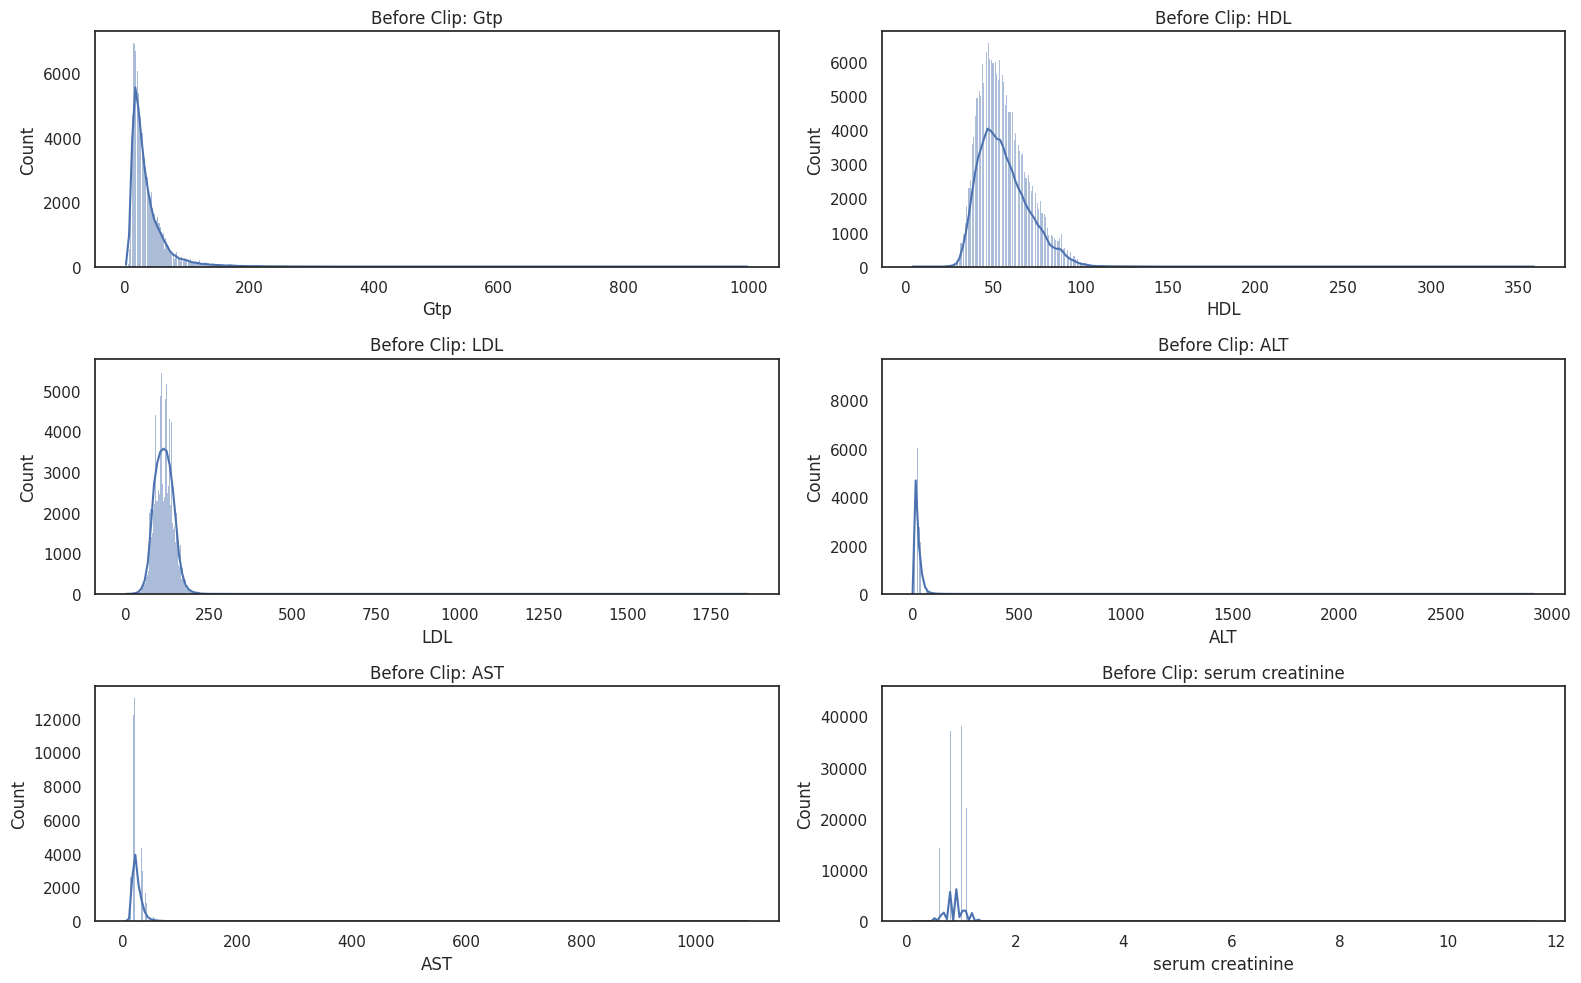

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Outlier handling")
for i, col in enumerate(train[["Gtp", "HDL", "LDL", "ALT", "AST", "serum creatinine"]].columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=train, x=col, kde=True)
    plt.title(f"Before Clip: {col}")
plt.tight_layout()
plt.show()

In [ ]:
# train 데이터에 대한 임계값 설정
train['Gtp'] = train['Gtp'].clip(lower = 0, upper = 300)
train['HDL'] = train['HDL'].clip(lower = 0, upper = 150)
train['LDL'] =  train['LDL'].clip(lower = 0, upper = 200)
train['ALT'] = train['ALT'].clip(lower = 0, upper = 150)
train['AST'] = train['AST'].clip(lower = 0, upper = 100)
train['serum creatinine'] = train['serum creatinine'].clip(lower = 0, upper = 3)

# test 데이터에 대한 임계값 설정
test['Gtp'] = test['Gtp'].clip(lower = 0, upper = 300)
test['HDL'] = test['HDL'].clip(lower = 0, upper = 150)
test['LDL'] = test['LDL'].clip(lower = 0, upper = 200)
test['ALT'] = test['ALT'].clip(lower = 0, upper = 150)
test['AST'] = test['AST'].clip(lower = 0, upper = 100)
test['serum creatinine'] = test['serum creatinine'].clip(lower = 0, upper = 3)

## 데이터 임계값 조정 후 그래프

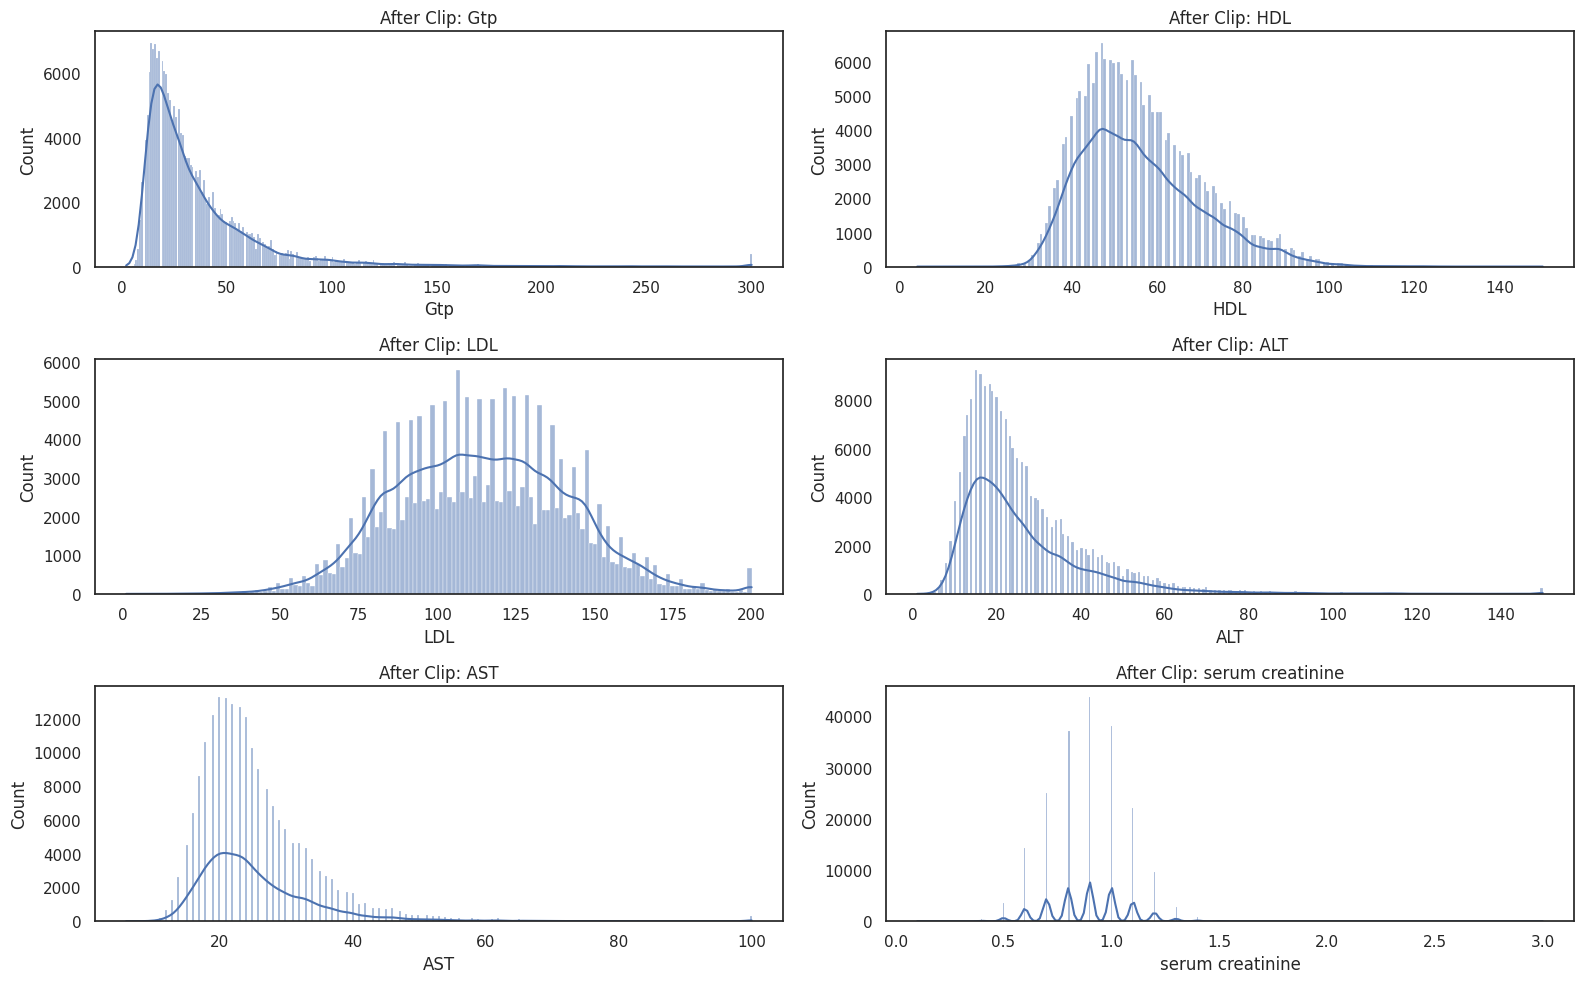

In [ ]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(train[["Gtp", "HDL", "LDL", "ALT", "AST", "serum creatinine"]].columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=train[col].clip(lower=0, upper={'Gtp':300, 'HDL':150, 'LDL':200, 'ALT':150, 'AST':100, 'serum creatinine':3}),
                 kde=True)
    plt.title(f"After Clip: {col}")
plt.tight_layout()
plt.show()

# EDA

In [ ]:
train.info() # 병합된 데이터

<class 'pandas.core.frame.DataFrame'>
Index: 192723 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  192723 non-null  int64  
 1   height(cm)           192723 non-null  int64  
 2   weight(kg)           192723 non-null  int64  
 3   waist(cm)            192723 non-null  float64
 4   eyesight(left)       192723 non-null  float64
 5   eyesight(right)      192723 non-null  float64
 6   hearing(left)        192723 non-null  int64  
 7   hearing(right)       192723 non-null  int64  
 8   systolic             192723 non-null  int64  
 9   relaxation           192723 non-null  int64  
 10  fasting blood sugar  192723 non-null  int64  
 11  Cholesterol          192723 non-null  int64  
 12  triglyceride         192723 non-null  int64  
 13  HDL                  192723 non-null  int64  
 14  LDL                  192723 non-null  int64  
 15  hemoglobin           19

In [ ]:
features = list(train.columns)
features.remove('smoking')
print(f'The features in the dataset: \n{features}')

The features in the dataset: 
['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


In [ ]:
# 누락된 값 확인
train.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [ ]:
# 누락된 값 확인
test.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

In [ ]:
# 중복행 제거
# 198240 -> 192723
train = train.drop_duplicates()
train.shape

(192723, 23)

In [ ]:
train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38978,40,170,65,77.0,1.5,1.5,1,1,110,62,...,79,91,16.1,1,0.9,28,43,36,1,1
38979,40,165,60,80.0,0.4,0.6,1,1,107,60,...,61,72,12.3,1,0.5,18,18,21,1,0
38980,45,155,55,75.0,1.5,1.2,1,1,126,72,...,76,131,12.5,2,0.6,23,11,12,0,0
38982,40,160,55,75.0,1.5,1.5,1,1,95,69,...,79,116,12.0,1,0.6,24,20,17,0,1


In [ ]:
pd.DataFrame(train.nunique())

# 모든 열에 누락/null 값이 없음

,0
age,18
height(cm),15
weight(kg),29
waist(cm),548
eyesight(left),20
eyesight(right),18
hearing(left),2
hearing(right),2
systolic,128
relaxation,94


In [ ]:
train.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
age,198240.0,44.271418,11.886308,20.0,40.0,40.0,55.0,85.0
height(cm),198240.0,165.153375,8.895587,130.0,160.0,165.0,170.0,190.0
weight(kg),198240.0,66.906709,12.656868,30.0,55.0,65.0,75.0,135.0
waist(cm),198240.0,82.817163,9.039363,51.0,77.0,83.0,89.0,129.0
eyesight(left),198240.0,1.007599,0.422827,0.1,0.8,1.0,1.2,9.9
eyesight(right),198240.0,1.002519,0.414241,0.1,0.8,1.0,1.2,9.9
hearing(left),198240.0,1.024248,0.153820,1.0,1.0,1.0,1.0,2.0
hearing(right),198240.0,1.023966,0.152943,1.0,1.0,1.0,1.0,2.0
systolic,198240.0,122.301488,12.920634,71.0,113.0,121.0,130.0,233.0
relaxation,198240.0,76.701085,9.135720,40.0,70.0,77.0,82.0,146.0


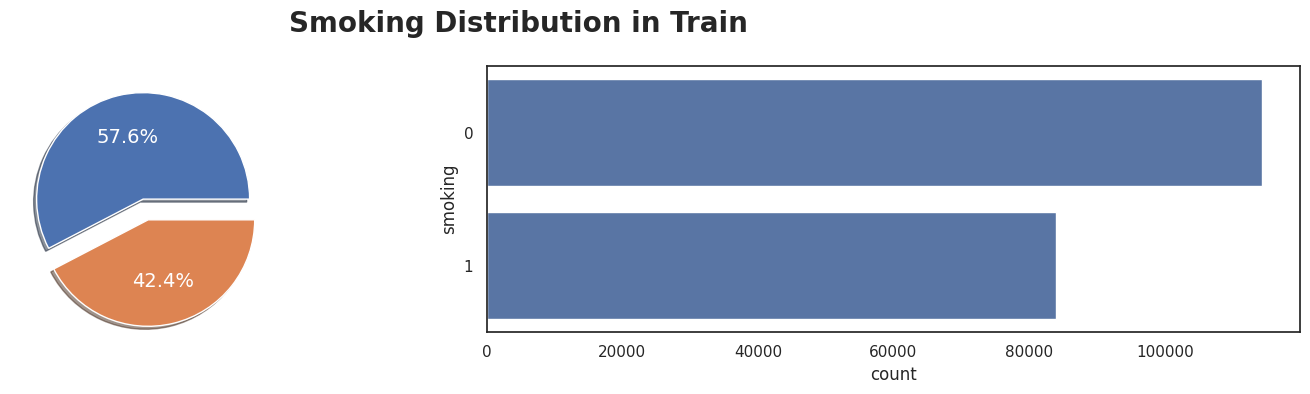

In [ ]:
# 병합 데이터의 흡연여부 확인
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax = ax.flatten()

ax[0].pie(
    train["smoking"].value_counts(),
    shadow=True,
    autopct='%1.1f%%',
    explode = (0, 0.2),
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data=train, y="smoking", ax=ax[1])

fig.suptitle('Smoking Distribution in Train', fontsize = 20, fontweight = 'bold')
plt.tight_layout()

## 각 데이터들의 상관관계

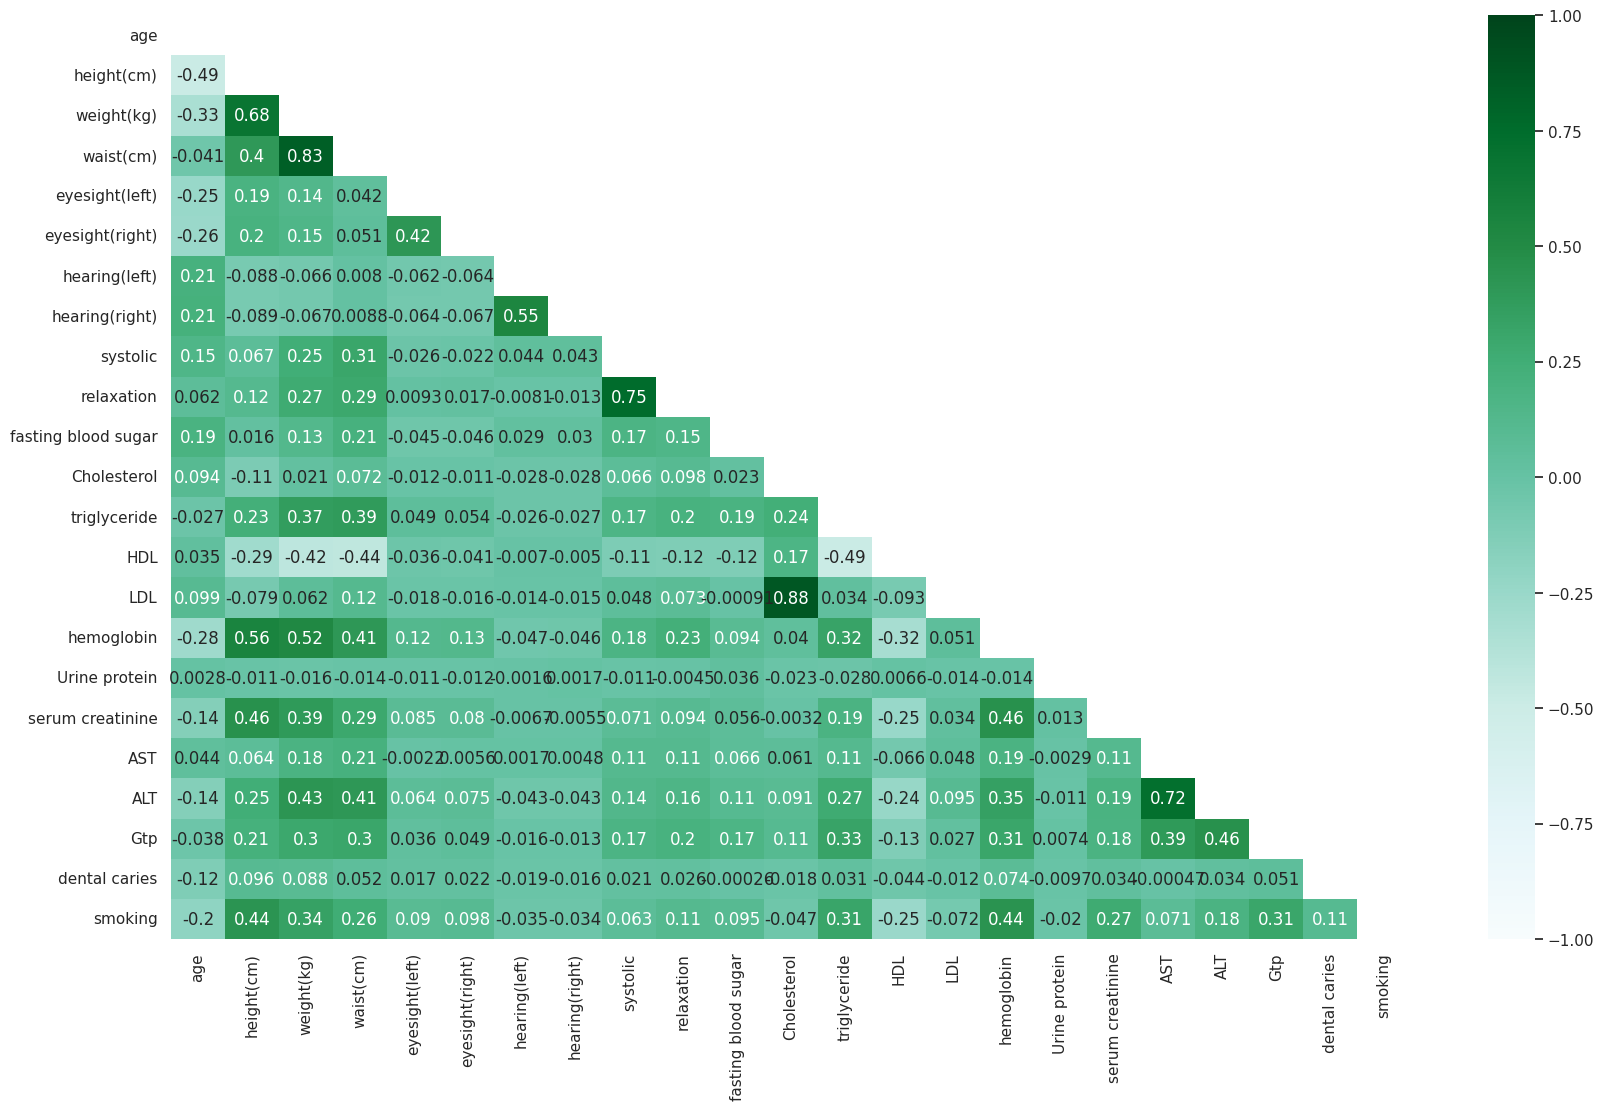

In [ ]:
mask = np.triu(np.ones_like(train.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(train.corr(), cmap="BuGn", annot=True, mask=mask,vmin=-1,vmax=1);

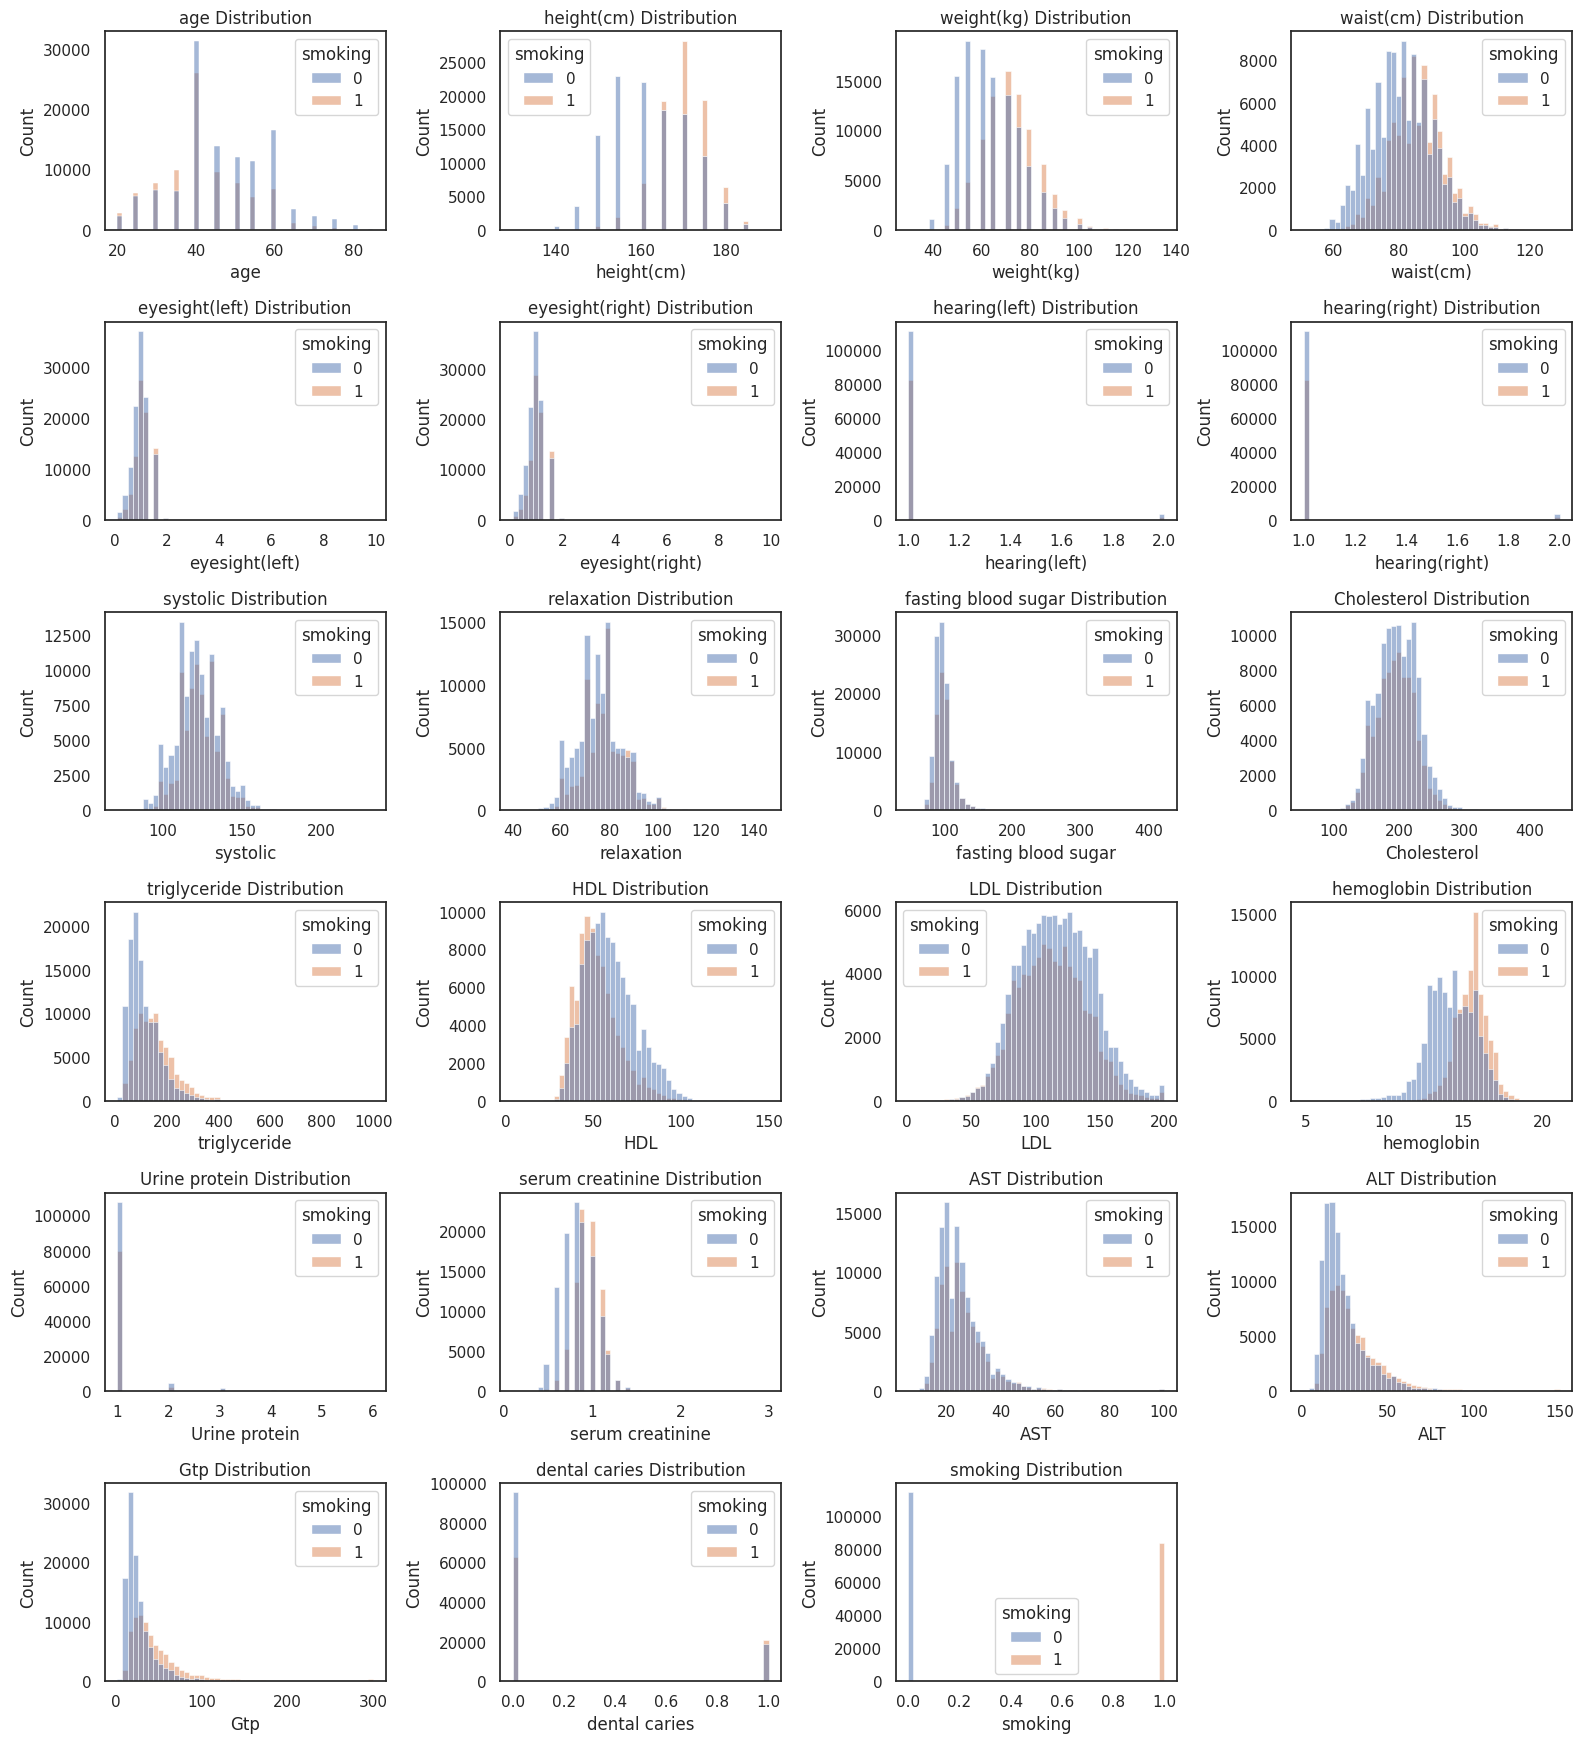

In [ ]:
# 각 데이터들 분포
num_cols = len(train.columns)
plt.figure(figsize=(16, num_cols*1.5))
for i, col in enumerate(train.columns):
    plt.subplot(num_cols//2 + num_cols%2, 4, i + 1)
    sns.histplot(x=col, hue='smoking', data=train, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

# 아래에서 일부 기능은 왜곡된 분포를 갖고 있고 다른 데이터는 버킷화되어 있음을 확인할 수 있습니다.
# 헤모글로빈 및 허리와 같은 특징은 흡연 분포에서 뚜렷한 차이를 보입니다.

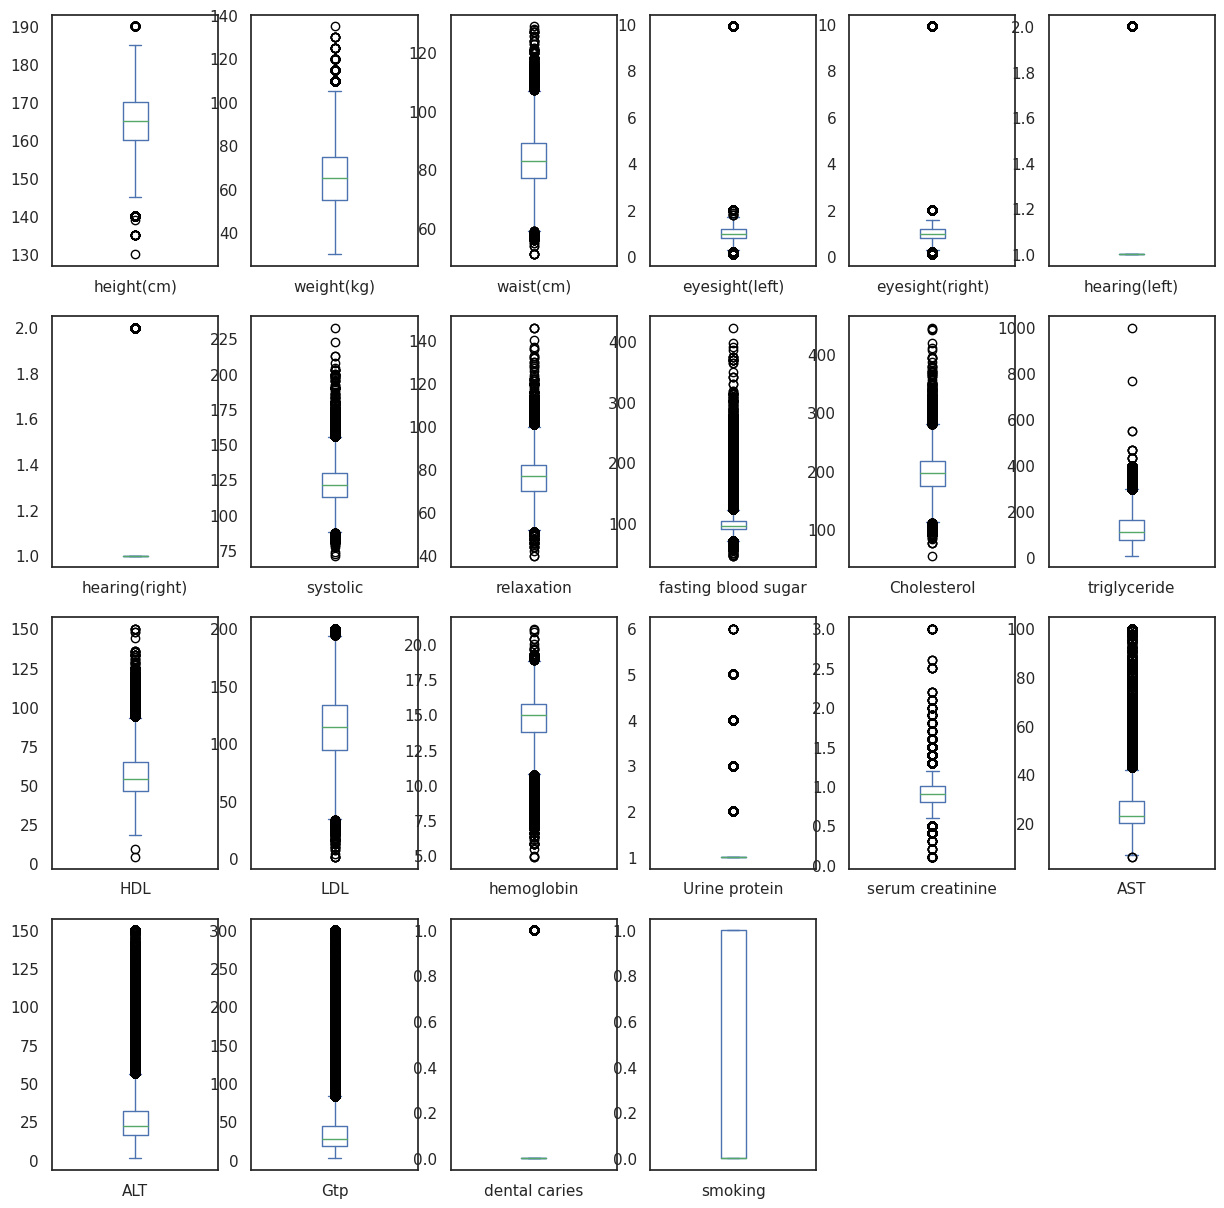

In [ ]:
train.iloc[:, 1:].plot(kind = "box", subplots = True, layout = (4, 6), figsize = (15, 15))
plt.show()

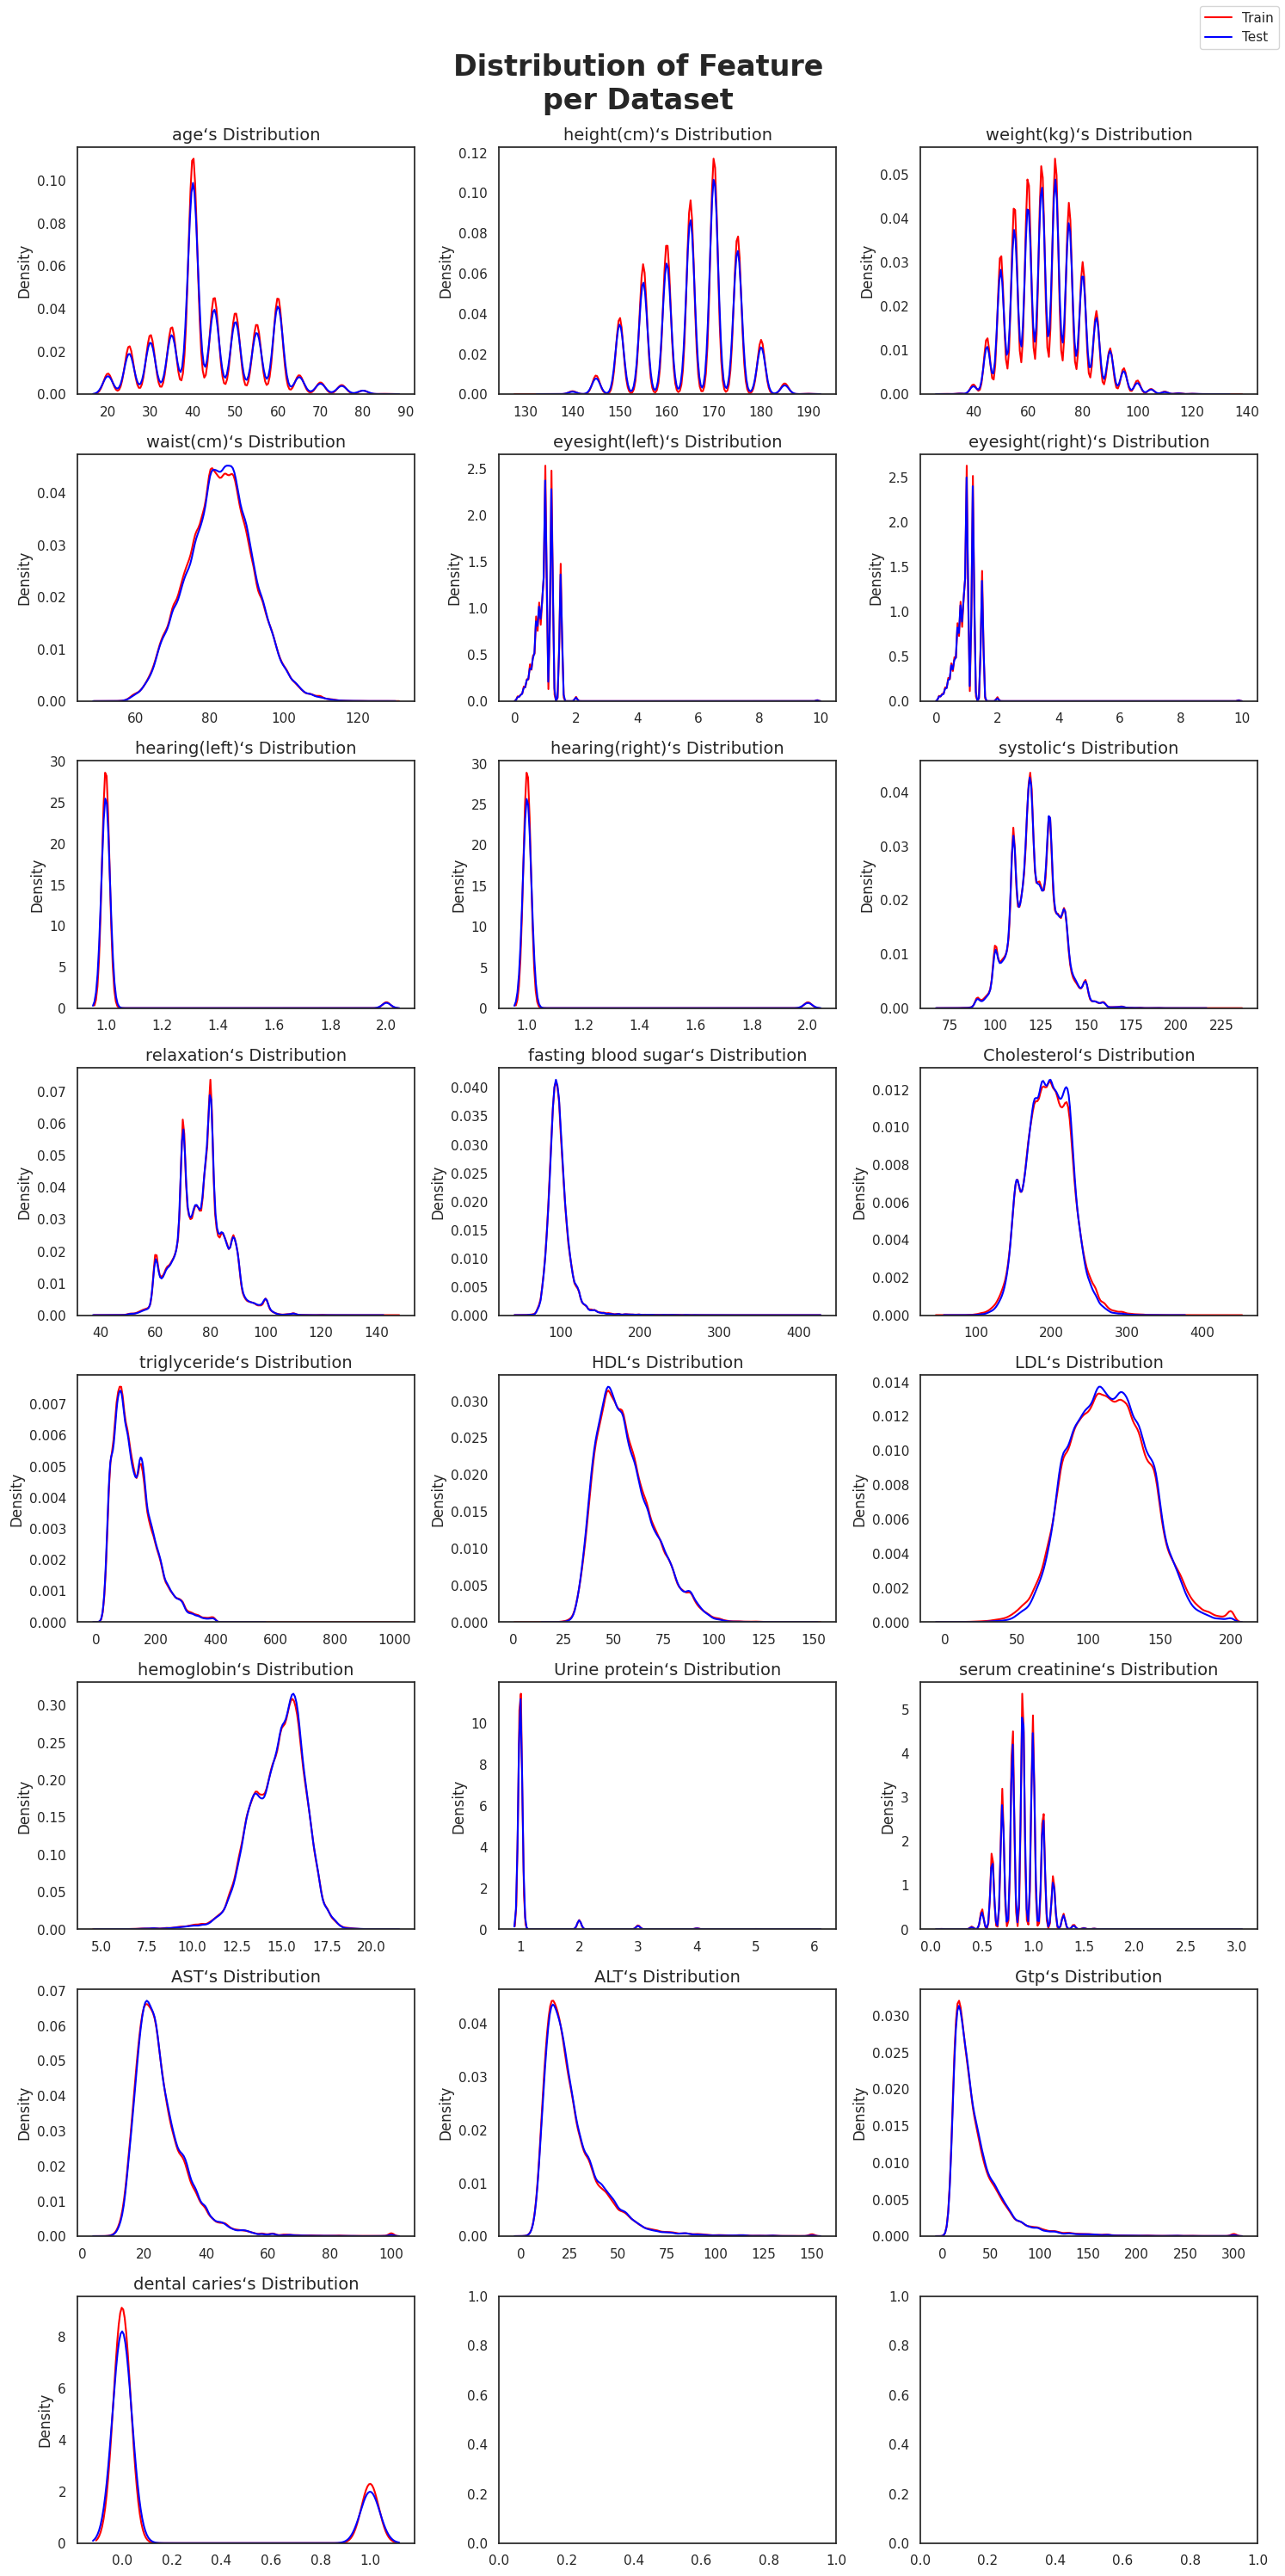

In [ ]:
# 데이터세트별 특성 분포
fig, ax = plt.subplots(8, 3, figsize = (15, 30))
ax = ax.flatten()

for i, column in enumerate(list(test)):
    sns.kdeplot(train[column], ax=ax[i], color="red")         # train(병합된 데이터)은 빨간색
    sns.kdeplot(test[column], ax=ax[i], color="blue")         # test는 파란색
    ax[i].set_title(f'{column}‘s Distribution', size = 14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

# 훈련 모델

In [ ]:
features = train.drop(["smoking"],axis=1).columns
X = train[features]
y = train["smoking"]

In [ ]:
skf = StratifiedKFold(n_splits = 7, random_state = 42, shuffle = True)
kfolds = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    kfolds.append([X.iloc[train_index,], X.iloc[test_index,], y.iloc[train_index,], y.iloc[test_index,]])

for i, (train_X, valid_X, train_y, valid_y) in enumerate(kfolds):
    print(i, train_X.shape, valid_X.shape, train_y.shape, valid_y.shape, train_y.mean(), valid_y.mean() )

0 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235816854990584 0.4235875706214689
1 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235816854990584 0.4235875706214689
2 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235816854990584 0.4235875706214689
3 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235816854990584 0.4235875706214689
4 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235816854990584 0.4235875706214689
5 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235816854990584 0.4235875706214689
6 (169920, 22) (28320, 22) (169920,) (28320,) 0.4235875706214689 0.4235522598870056


In [ ]:
preds_list = []
model_list = []

for i, (train_X, valid_X, train_y, valid_y) in enumerate(kfolds):
    dtrain = lgb.Dataset(train_X, label = train_y)

    params = {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'boosting_type': 'gbdt',
            'random_seed': 6, 'lambda_l1': 3.1422772805786794, 'lambda_l2': 0.3912821668022086,
            'num_leaves': 120, 'feature_fraction': 0.24955364718656628, 'bagging_fraction': 0.9712078900905778,
            'bagging_freq': 9, 'min_child_samples': 200, 'num_boost_round': 600, 'learning_rate': 0.1}

    for seed_i in [1, 3333, 6666, 9999]:
        params_i = copy.deepcopy(params)
        params_i["random_seed"] = seed_i

        lgb_clf = lgb.train(params_i, dtrain)
        pred_prob = lgb_clf.predict(valid_X)                    # 예측된 확률 계산
        auc_val = metrics.roc_auc_score(valid_y, pred_prob)
        print(f"데이터:{i}, 난수 값: {seed_i}, auc: {auc_val}")
        model_list.append(copy.deepcopy(lgb_clf))
        pred_prob = lgb_clf.predict(test[features])
        preds_list.append(pred_prob)

데이터:0, 난수 값: 1, auc: 0.8788207112082365
데이터:0, 난수 값: 3333, auc: 0.8787190682445074
데이터:0, 난수 값: 6666, auc: 0.8789924941491973
데이터:0, 난수 값: 9999, auc: 0.8787495958589154
데이터:1, 난수 값: 1, auc: 0.8721568414252926
데이터:1, 난수 값: 3333, auc: 0.8716565215032472
데이터:1, 난수 값: 6666, auc: 0.8718754542374207
데이터:1, 난수 값: 9999, auc: 0.8724189816110394
데이터:2, 난수 값: 1, auc: 0.8730651630670978
데이터:2, 난수 값: 3333, auc: 0.8741566657153299
데이터:2, 난수 값: 6666, auc: 0.8745638810094258
데이터:2, 난수 값: 9999, auc: 0.8736001010383352
데이터:3, 난수 값: 1, auc: 0.8724894024545795
데이터:3, 난수 값: 3333, auc: 0.8728205131923824
데이터:3, 난수 값: 6666, auc: 0.8734660307826205
데이터:3, 난수 값: 9999, auc: 0.8731169343877512
데이터:4, 난수 값: 1, auc: 0.874209049835202
데이터:4, 난수 값: 3333, auc: 0.8742917419830951
데이터:4, 난수 값: 6666, auc: 0.8735258042397371
데이터:4, 난수 값: 9999, auc: 0.8744459018398603
데이터:5, 난수 값: 1, auc: 0.8775268877913157
데이터:5, 난수 값: 3333, auc: 0.8769502386199305
데이터:5, 난수 값: 6666, auc: 0.8774139795352842
데이터:5, 난수 값: 9999, auc: 0.8763

In [ ]:
# 피쳐 중요도 시각화
def plotImportance(modelNames,models):
    plt.subplots(len(modelNames),1,figsize=(14,5*len(modelNames)),dpi=300)
    for ind,modelName in enumerate(modelNames):
        history = pd.DataFrame()
        history["cols"] = X_test.columns
        history["imp"] = models[ind].get_feature_importance()
        history.sort_values("imp",inplace=True,ascending=False)
        history.reset_index(drop=True)
        plt.subplot(len(modelNames),1,ind+1)
        sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
        plt.title("Feature Imporance of "+modelName)

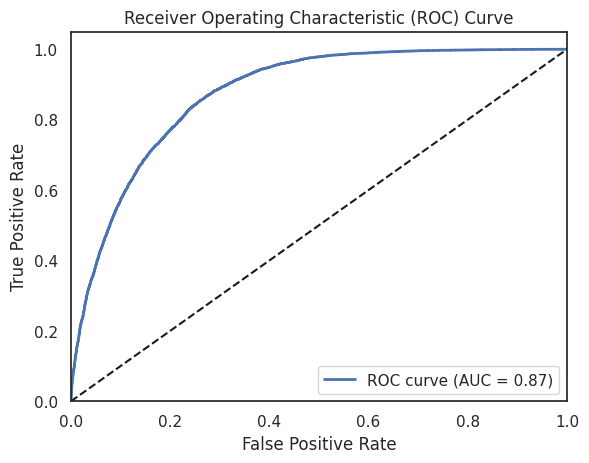

In [ ]:
pred_prob = lgb_clf.predict(valid_X)

# ROC 곡선 생성
fpr, tpr, thresholds = roc_curve(valid_y, pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

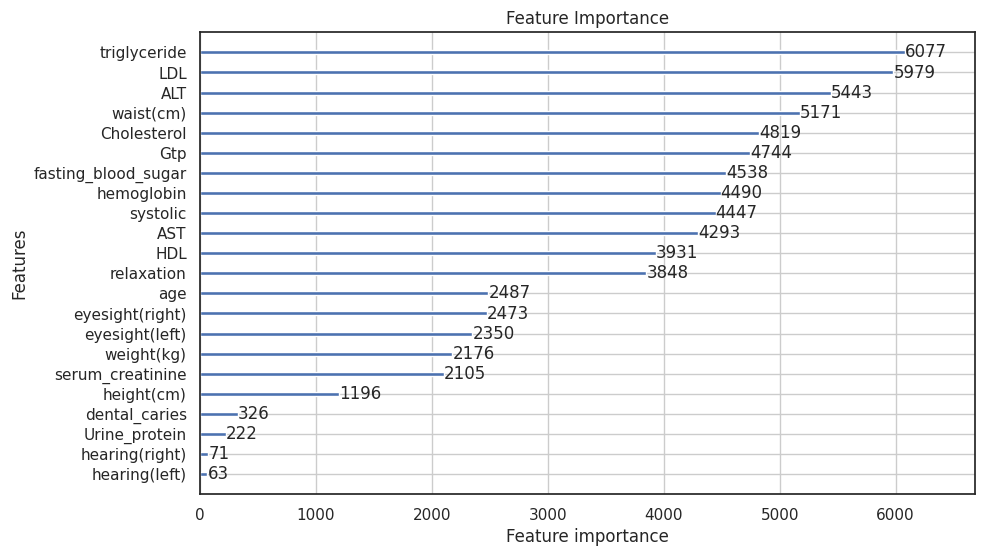

In [ ]:
# 피쳐 중요도 시각화
lgb.plot_importance(model, figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [ ]:
submission["smoking"] = np.mean(preds_list, axis = 0)

In [ ]:
submission.to_csv("submission.csv", index = False)